In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.special import erfc

import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from datetime import datetime
from datetime import timedelta
import re, os
import h5py
import pandas as pd

In [2]:
import sys
sys.path.insert(0,'../../')
sys.path.insert(0,'../../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
from Waveform import Waveform
from SiPM import SiPM

In [4]:
#load data from files using the SiPM class
data=SiPM(Path='C:/Data/20220525/',Selection='*V*.h5')

#load the Channel attribute
data.Ch=[Waveform(ID=1,Pol=-1)]
print (len(data.Files))

9


In [26]:
#loop over files and load data using the ImportDataFromHDF5 function in Dataset class

data.Files=natsorted(data.Files)
max_amp_all_st=[]
for File in data.Files:
    loaded_data=SiPM(Path=File) # Call the SiPM Class
    loaded_data.Ch=[Waveform(ID=2,Pol=-1)] # Since we only have data from a single channel, we store it in an array
    loaded_data.ImportDataFromHDF5(File,loaded_data.Ch,var=[]) #Import data from the HD5 file with empty var array since we don't need trigger or time stamp
    
    loaded_data.get_sampling()

    loaded_data.sampling_freq
    
    loaded_data.shaping_time=[2e-6,5e-6,10e-6] #List of shaping times to shape the signal with

    loaded_data.setup_butter_filter() # calculate the butterworth filter coefficients 
    # print(loaded_data.Ch[0].Amp[0])
    
    for waveform in loaded_data.Ch[0].Amp: #loop over the waveforms inside the file
        y=loaded_data.get_filtered_waveform(waveform) # return the filtered waveform
    
        max_amp=loaded_data.Ch[0].GetAllMaxima(y)
        # print(max_amp)
        max_amp_all_st.append(max_amp)
        # max_array_sh1.append(max_amp[0])
        # max_array_sh2.append(max_amp[1])
        # max_array_sh3.append(max_amp[2])
        # print(max_array_sh1)
        # plt.plot(loaded_data.Ch[0].Time,waveform,color='b')
        # [plt.plot(loaded_data.Ch[0].Time,y1) for y1 in y]
        # plt.xlim(500,550)
        # plt.show()
max_amp_all_st=np.array(max_amp_all_st)      

In [51]:
print(max_amp_all_st[0:100])

[[106.89544725 111.42156905 109.21942854]
 [107.39153699 111.85345835 109.67615462]
 [109.41328699 113.6703932  111.67119786]
 [109.37267941 113.94659214 111.71161509]
 [109.62249717 113.98735616 111.98727027]
 [109.3560634  113.86404772 111.73940501]
 [109.75360911 114.16049466 111.89533488]
 [109.92216167 114.39661072 112.15851095]
 [110.22494837 114.52778414 112.48419078]
 [109.79808583 114.24247373 111.99147089]
 [109.99877655 114.33463983 112.22750801]
 [109.6227214  114.1355773  111.94811981]
 [107.19921866 111.72908043 109.44174225]
 [110.08529396 114.14502492 112.18454822]
 [109.46461807 113.95918663 111.95630707]
 [109.60014639 114.01089666 111.95811404]
 [110.28675717 114.68183418 112.4511243 ]
 [109.87985155 114.36805293 112.25104941]
 [109.97897486 114.43912956 112.20404165]
 [109.94028771 114.18306927 112.02940324]
 [109.8794086  114.37531373 112.1257582 ]
 [110.12016058 114.72002918 112.53984295]
 [109.77954212 114.14245789 111.92714125]
 [107.43564741 112.10104074 109.99

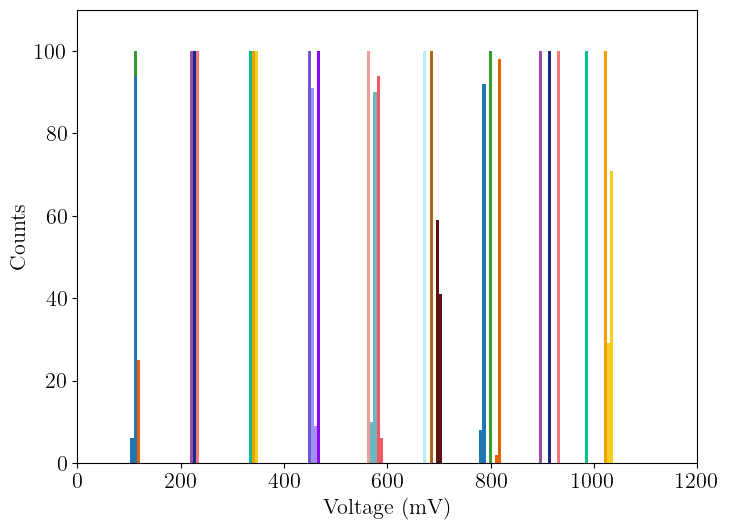

In [45]:
BINS=np.linspace(0,1200,200)
plt.figure(figsize=(8,6))
[plt.hist(max_amp_all_st[100*i:(i+1)*100],bins=BINS,histtype='stepfilled') for i in range(0,9,1)]
# plt.legend(loc='best')
plt.ylim(0,110)
plt.xlabel('Voltage (mV)')
plt.ylabel('Counts')
plt.show()

In [61]:
print(max_amp_all_st[0:100])
# print(np.mean(max_amp_all_st[0:100]))

[[106.89544725 111.42156905 109.21942854]
 [107.39153699 111.85345835 109.67615462]
 [109.41328699 113.6703932  111.67119786]
 [109.37267941 113.94659214 111.71161509]
 [109.62249717 113.98735616 111.98727027]
 [109.3560634  113.86404772 111.73940501]
 [109.75360911 114.16049466 111.89533488]
 [109.92216167 114.39661072 112.15851095]
 [110.22494837 114.52778414 112.48419078]
 [109.79808583 114.24247373 111.99147089]
 [109.99877655 114.33463983 112.22750801]
 [109.6227214  114.1355773  111.94811981]
 [107.19921866 111.72908043 109.44174225]
 [110.08529396 114.14502492 112.18454822]
 [109.46461807 113.95918663 111.95630707]
 [109.60014639 114.01089666 111.95811404]
 [110.28675717 114.68183418 112.4511243 ]
 [109.87985155 114.36805293 112.25104941]
 [109.97897486 114.43912956 112.20404165]
 [109.94028771 114.18306927 112.02940324]
 [109.8794086  114.37531373 112.1257582 ]
 [110.12016058 114.72002918 112.53984295]
 [109.77954212 114.14245789 111.92714125]
 [107.43564741 112.10104074 109.99

In [62]:
for value in max_amp_all_st[0:5]:
    print(value)
# [mean_sh1.append((max_array_sh1[9*i])) for i in np.arange(0,100,1)]
# [mean_sh2.append(np.mean(max_array_sh2[100*i:100*(i+1)])) for i in np.arange(0,9,1)]
# [mean_sh3.append(np.mean(max_array_sh3[100*i:100*(i+1)])) for i in np.arange(0,9,1)]
# plt.figure(figsize=(8,6))
# plt.scatter(np.arange(0.5,5,0.5),mean_sh1,color=colors[0],label='2$\mu$s')
# # plt.scatter(np.arange(0.5,5,0.5),mean_sh2,color=colors[1],label='5$\mu$s')
# # plt.scatter(np.arange(0.5,5,0.5),mean_sh3,color=colors[2],label='10$\mu$s')
# # plt.legend(loc='best')
# plt.xlim(0,5)
# plt.xlabel('Function Gen Voltage (V)')
# plt.ylabel('Mean of Max Amplitude (mV)')
# plt.show()
# print(mean_sh1)


[106.89544725 111.42156905 109.21942854]
[107.39153699 111.85345835 109.67615462]
[109.41328699 113.6703932  111.67119786]
[109.37267941 113.94659214 111.71161509]
[109.62249717 113.98735616 111.98727027]
